<a href="https://colab.research.google.com/github/rahemSorour/Final-Project-Report/blob/main/analyse_de_sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Importer la bibliothèque***

In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

***Chargement de données***

In [ ]:
data = pd.read_csv('/content/Tweets.csv')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)

print(data['airline_sentiment'].value_counts())
print(data['airline_sentiment'].value_counts(normalize=True))
data.head()

(14640, 15)
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,569376145000390656,negative,1.0000,Customer Service Issue,1.0000,United,NaN,tweets1971,NaN,0,@united we have tried to change our flight THR...,NaN,2015-02-21 22:00:26 -0800,Boston,NaN
1,568450017649778688,positive,1.0000,NaN,NaN,United,NaN,melanie_seibert,NaN,0,@united Joni did a great job on flight 5653 to...,NaN,2015-02-19 08:40:20 -0800,Texas,Central Time (US & Canada)
2,569367682811715585,negative,0.6554,Can't Tell,0.6554,United,NaN,WM_j_MW,NaN,0,@united Suck,NaN,2015-02-21 21:26:48 -0800,"Wake Forest, NC",Eastern Time (US & Canada)
3,569706873525391360,negative,1.0000,Late Flight,0.7059,American,NaN,monumentsinking,NaN,0,.@AmericanAir Flight 654 Delayed / Flight 409 ...,NaN,2015-02-22 19:54:37 -0800,PDX JFK SFO BDL,Pacific Time (US & Canada)
4,569234806543929344,negative,1.0000,Bad Flight,0.6617,US Airways,NaN,POnions,NaN,0,@USAirways And now your half assed plane is f...,NaN,2015-02-21 12:38:48 -0800,"CT, USA",Central Time (US & Canada)


**Ne garder que les colonnes nécessaires**

In [ ]:
data = data[['airline_sentiment', 'text']]
data.head(10)

,airline_sentiment,text
0,negative,@united we have tried to change our flight THR...
1,positive,@united Joni did a great job on flight 5653 to...
2,negative,@united Suck
3,negative,.@AmericanAir Flight 654 Delayed / Flight 409 ...
4,negative,@USAirways And now your half assed plane is f...
5,positive,@USAirways thanks! It's hectic for everyone bu...
6,negative,@AmericanAir 250 I'm not sure if I'm rebooked ...
7,negative,@USAirways Why were we loaded onto the plane (...
8,negative,@SouthwestAir over 15 minutes without talking...
9,negative,@united very missed daughter suppose to dpt OR...


***Exploration de données***

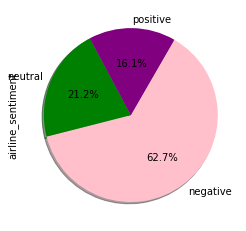

In [ ]:
colors = ["pink", "green", "purple", "orange"]
data['airline_sentiment'].value_counts().plot.pie( autopct='%1.1f%%', shadow=True,startangle=60, counterclock=False,colors=colors)
plt.show()

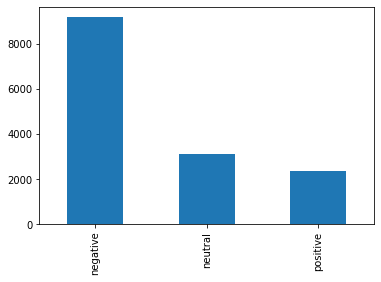

In [ ]:
data['airline_sentiment'].value_counts().sort_index().plot.bar()

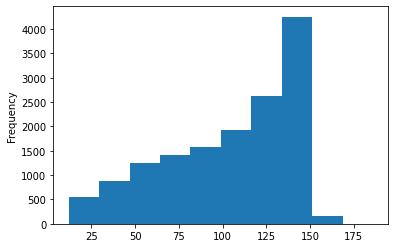

In [ ]:
data['text'].str.len().plot.hist()

***Prétraitement***

In [ ]:
data['text'] = data['text'].apply(lambda x: x.lower().strip())#transform text to lowercase
data['text'] = data['text'].apply(lambda x: re.sub('(@[A-Za-z0-9]+)', '', x))
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'] = data['text'].apply(lambda x: re.sub('(\w+:\/\/S+)', '', x))
data['text'] = data['text'].apply(lambda x: re.sub('(\d+)', '', x))
data['text'].head(10)


0    united we have tried to change our flight thre...
1    united joni did a great job on flight 5653 to ...
2                                          united suck
3    americanair flight 654 delayed  flight 409 you...
4    usairways  and now your half assed plane is fa...
5    usairways thanks its hectic for everyone but t...
6    americanair 250 im not sure if im rebooked now...
7    usairways why were we loaded onto the plane 4 ...
8    southwestair  over 15 minutes without talking ...
9    united very missed daughter suppose to dpt ord...
Name: text, dtype: object

In [ ]:
lemmatizer = WordNetLemmatizer()
data['text'] =data['text'].apply(lambda x: lemmatizer.lemmatize(x))
print(data['text'].head(50))

In [ ]:
tokenizer = Tokenizer(num_words=14640, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    5,   38,   22,  267,    1,  127,   53,
           8,  482,  229,    9,    2,   97,   10,   92,  757,  610,   47],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    5, 6617,  115,    4,  114,
         402,    9,    8, 6618,    1,  297,   36,    7,    4,  114,    8],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    5,  624],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   13,
           8, 3670,   77,    8, 6619,    6, 1257,   11,  144,    8, 6620,
        2056,   19,   15,  573,    7,  482,   56,   36,    7,    2, 2723],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   12,   10,   

In [ ]:
y = pd.get_dummies(data['airline_sentiment']).values
[print(data['airline_sentiment'][i], y[i]) for i in range(0,5)]

negative [1 0 0]
positive [0 0 1]
negative [1 0 0]
negative [1 0 0]


[None, None, None, None]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

 ***Création de modèle***

In [ ]:
model = Sequential()
model.add(Embedding(14640, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 256)           3747840   
                                                                 
 dropout_1 (Dropout)         (None, 33, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 33, 256)           525312    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 4,799,235
Trainable params: 4,799,235
Non-trainable params: 0
_________________________________________________________________


***Entraînement de model***

In [ ]:
batch_size = 32
epochs = 10

model_hist=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=2)

Epoch 1/10
366/366 - 228s - loss: 0.6427 - accuracy: 0.7335 - 228s/epoch - 623ms/step
Epoch 2/10
366/366 - 222s - loss: 0.4049 - accuracy: 0.8474 - 222s/epoch - 607ms/step
Epoch 3/10
366/366 - 222s - loss: 0.2833 - accuracy: 0.8984 - 222s/epoch - 607ms/step
Epoch 4/10
366/366 - 222s - loss: 0.2011 - accuracy: 0.9277 - 222s/epoch - 608ms/step
Epoch 5/10
366/366 - 223s - loss: 0.1443 - accuracy: 0.9495 - 223s/epoch - 610ms/step
Epoch 6/10
366/366 - 225s - loss: 0.1081 - accuracy: 0.9641 - 225s/epoch - 615ms/step
Epoch 7/10
366/366 - 226s - loss: 0.0938 - accuracy: 0.9664 - 226s/epoch - 617ms/step
Epoch 8/10
366/366 - 230s - loss: 0.0772 - accuracy: 0.9735 - 230s/epoch - 628ms/step
Epoch 9/10
366/366 - 222s - loss: 0.0618 - accuracy: 0.9774 - 222s/epoch - 608ms/step
Epoch 10/10
366/366 - 225s - loss: 0.0579 - accuracy: 0.9810 - 225s/epoch - 615ms/step


In [ ]:
#loss,acc=model.evaluate(X_test)
#print("test accuracy :",acc)
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Test loss: %.4f' % loss)
print('Test accuracy: %.4f' % acc)

46/46 - 5s - loss: 1.0470 - accuracy: 0.7746 - 5s/epoch - 99ms/step
Test loss: 1.0470
Test accuracy: 0.7746


In [ ]:
print(model_hist.history.keys())

dict_keys(['loss', 'accuracy'])


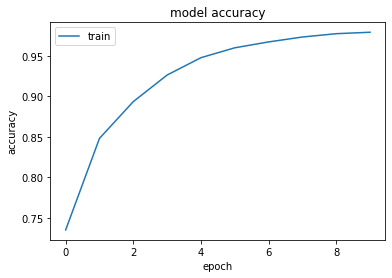

In [ ]:
# summarize history for accuracy
plt.plot(model_hist.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

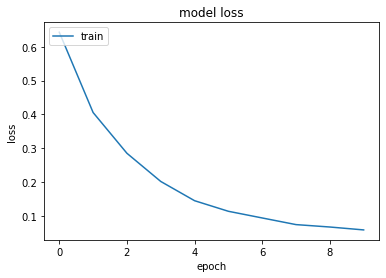

In [ ]:
# summarize history for loss
plt.plot(model_hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

***Test de model***

In [ ]:
predictions = model.predict(X_test)

[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 10)]

americanair thanks for doing that but now its telling me to go to the airport and check in with an agentwhats up httptcopfsenjk5pw [0.06657861 0.08364379 0.8497776 ] [0 0 1]
jetblue pdx to jfk was suuuuper hot [0.00546552 0.72365993 0.2708746 ] [1 0 0]
southwestair when can i start flight booking problems for next years super bowl time help [9.99835253e-01 1.52480061e-04 1.22928295e-05] [1 0 0]
united thanks for the 2hr delay and then no ground crew when we landed at least you didnt break my httptcogcwvfuopl2 [9.9997067e-01 2.8261820e-05 1.0333465e-06] [1 0 0]
jetblue the pilot just stated that after 22 years of flying he has never experienced anything like this gettingoffplane [9.9945563e-01 5.2232156e-04 2.1990663e-05] [1 0 0]
jetblue goodwill now at 12500  27000 x   fine   still want your new ceo to make a public apology to all passengers of flight 136 [9.9987829e-01 1.1668876e-04 4.9675245e-06] [1 0 0]
united do you have an email address i can write my account to might be less like

[None, None, None, None, None, None, None, None, None, None]

In [ ]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1

    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)
print("pos_acc", real_pos/pos_count*100, "%")
print("neg_acc", real_neg/neg_count*100, "%")
print("neg_acc", real_neu/neu_count*100, "%")


Positive predictions: 461
Neutral predictions: 543
Negative predictions: 1924
Real positive: 506
Real neutral: 613
Real negative: 1809
